# Running inference on the Hierarchical Dirichlet-Hawkes process 

In this notebook, we will use run the inference algorithm on data that we first generate from the HDHP.

In [1]:
%matplotlib inline
import datetime
import string
import hdhp
import notebook_helpers
import seaborn as sns

In [2]:
vocabulary = ['word' + str(i) for i in range(100)]  # the `words` of our documents
doc_min_length = 5
doc_length = 10
words_per_pattern = 50

alpha_0 = (2.5, 0.75)
mu_0 = (2, 0.5)
omega = 3.5

num_patterns = 10

process = hdhp.HDHProcess(num_patterns=num_patterns, alpha_0=alpha_0,
                          mu_0=mu_0, vocabulary=vocabulary,
                          omega=omega, words_per_pattern=words_per_pattern,
                          random_state=12)

In [3]:
process.reset()  # removes any previously generated data
for i in range(10):
    _= process.sample_user_events(min_num_events=100, 
                                  max_num_events=5000,
                                  t_max=365)
print 'Total #events', len(process.events)

Total #events 11862


We can show the annotated events that belong to pattern 1 which happened before `t=50`. This will include information about the timestamp of the event, the pattern that it belongs to, the task that it belongs to, the user who generated the event and its content.

In [5]:
print process.show_annotated_events(patterns=[1], T_max=50)

 39.7 pattern=  1 task= 13 (u=0)  word8 word9 word9 word9 word11 word11 word12 word12 word12 word13 word23 word25 word29 word31 word41 word41 word47 word60 word63 word67 word86 word88 word94
 28.7 pattern=  1 task= 23 (u=3)  word9 word31 word40 word53 word60 word60 word60 word70 word70 word73 word93 word96 word98
0.906 pattern=  1 task=  4 (u=5)  word1 word9 word11 word13 word13 word18 word24 word25 word27 word31 word40 word67 word73 word73 word73 word82 word90 word92
 1.26 pattern=  1 task=  4 (u=5)  word27 word40 word41 word69 word70 word73 word74
 5.21 pattern=  1 task= 19 (u=5)  word5 word9 word13 word40 word65 word67 word67 word73 word94 word96 word98
 7.15 pattern=  1 task= 29 (u=5)  word1 word9 word11 word12 word18 word18 word21 word51 word51 word61 word67 word70 word73 word74 word94 word96 word97
 28.1 pattern=  1 task= 90 (u=5)  word29 word47 word53 word69 word73 word90 word94
 28.5 pattern=  1 task= 93 (u=5)  word5 word5 word8 word13 word13 word13 word24 word25 word27 word41 

We can also show the content distribution for the generated patterns. Below, we pick the first pattern to demonstrate this capability.

In [7]:
print process.show_pattern_content(patterns=[1], detail_threshold=100)

___Pattern 1___ 
word41 : 147
word96 : 122
word53 : 117
word9 : 116
word31 : 106
word73 : 102
word47 : 100
word67 word94 word24 word65 word13 word60 word90 word70 word11 word88 word40 word12 word86 word18 word51 word25 word23 word97 word74 word27 word57 word69 word55 word93 word8 word5 word92 word81 word98 word7 word45 word63 word82 word14 word58 word2 word89 word21 word87 word1 word32 word29 word61


# Running inference 

In order to infer the model on a given dataset, we need to run the SMC particle filtering algorithm. We need to pick our priors for the time kernel parameter and the activity rate parameter, as well as the time decay parameter. Finally, we need to pick a number of particles that we want to use to explore the space.

Calling the `infer` function will generate a temporary log file, which stores information about the runtime of the model inference. The function returns a particle (sampled according to its likelihood) and a list of floats that report how detegenerate were our particles at each resampling round.

In [8]:
particle, norms = hdhp.infer(process.events, alpha_0=alpha_0, mu_0=mu_0,
                             omega=omega, num_particles=10, seed=512)

Created temporary log file /Users/cmav/repos/hdhp.py/examples/tmpVScjtH.log


For the moment, the above process is single threaded, but it can also be parallelized.

We can now export the particle to a process object, and use it to explore the inferred data. For example, we can print the inferred content distributions, or we can plot the user timelines.

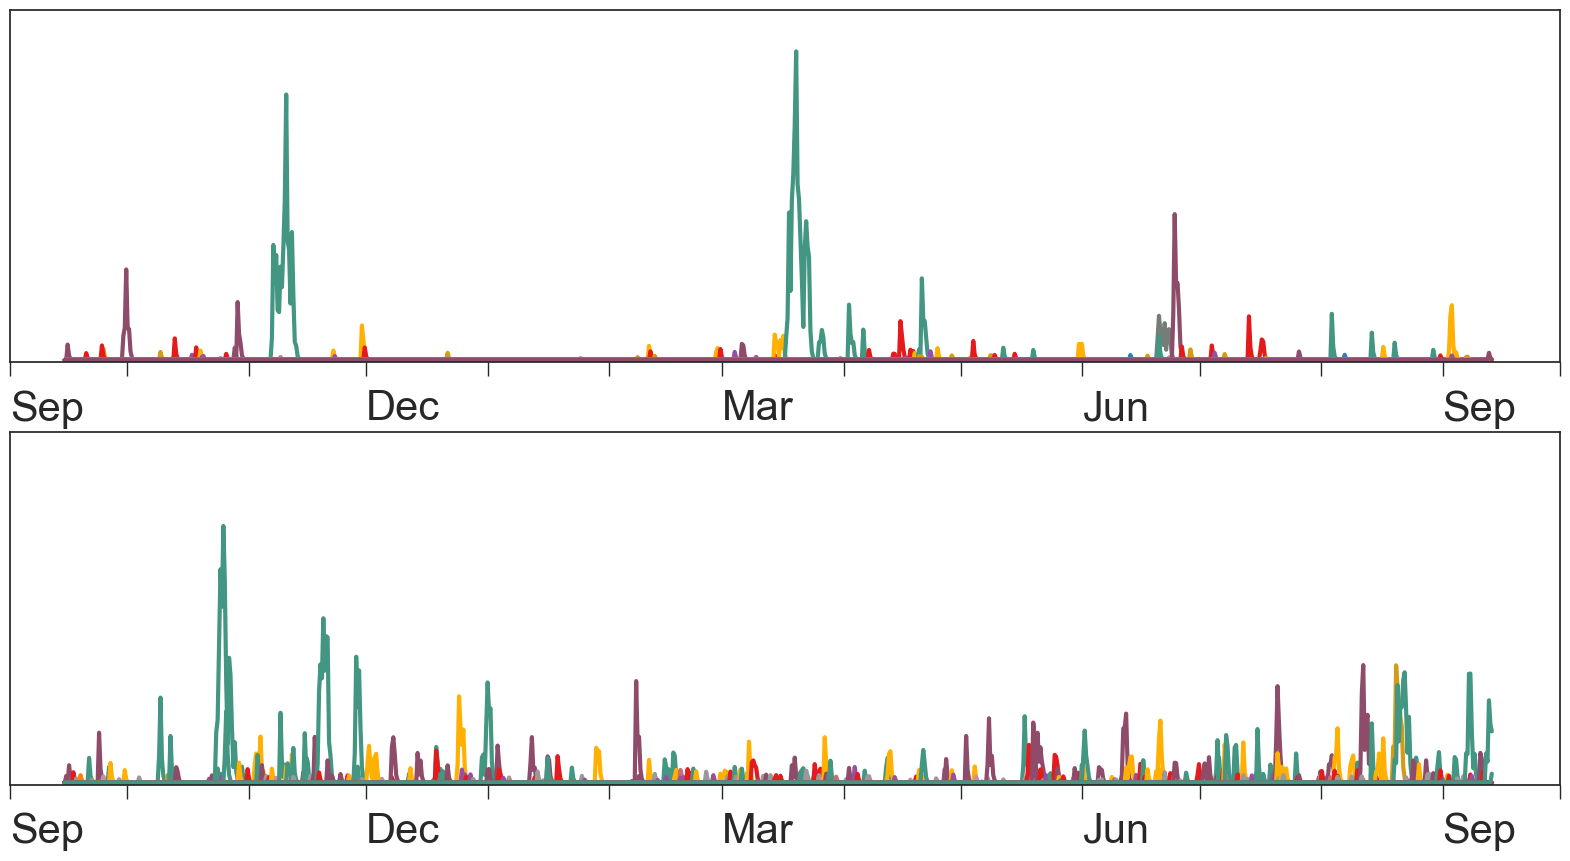

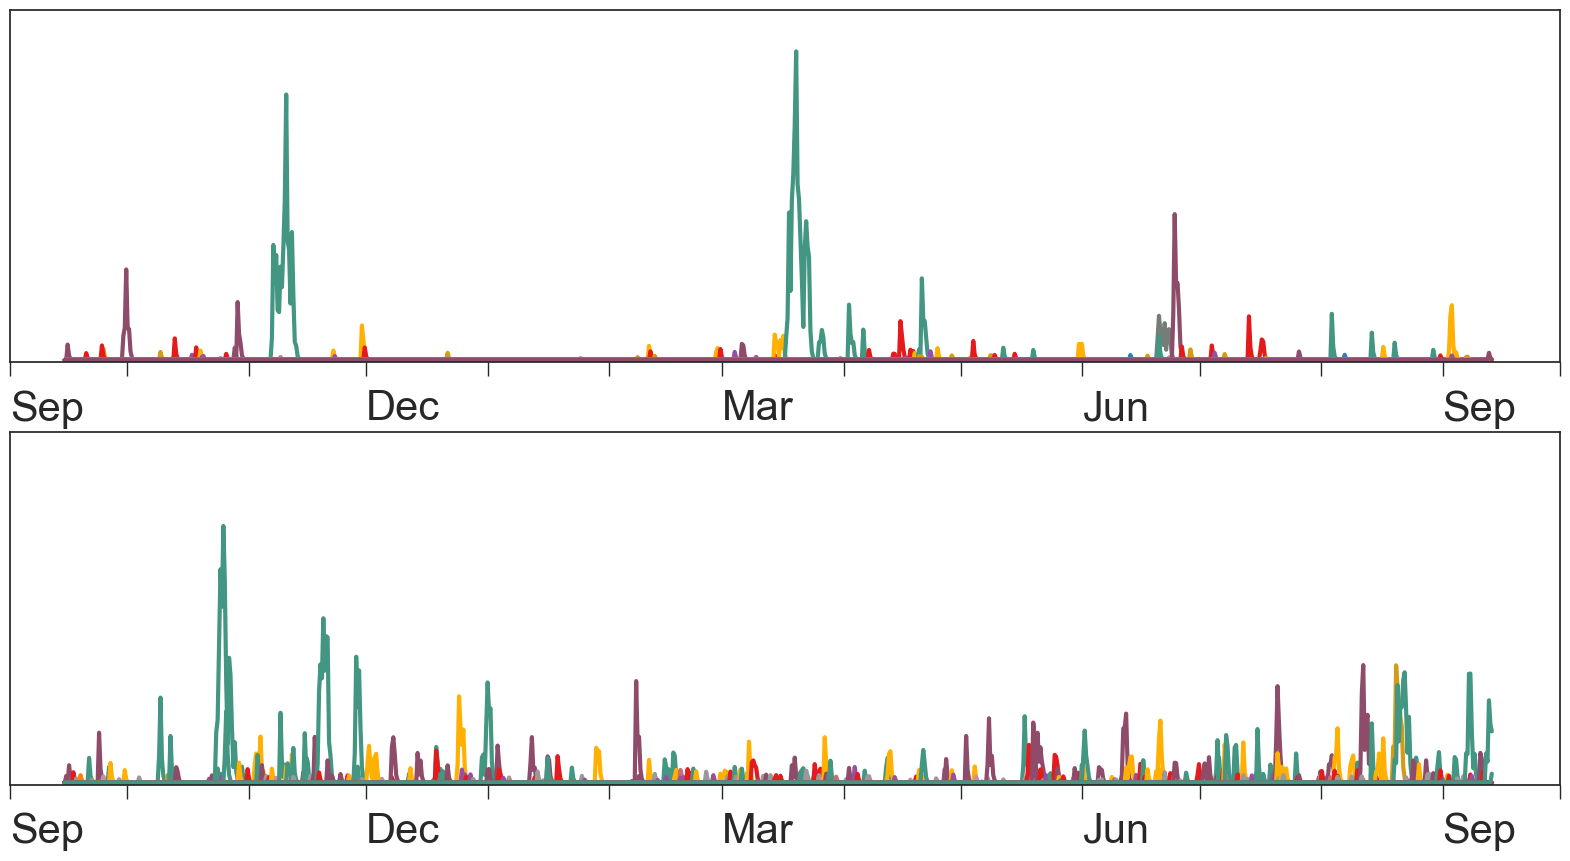

In [9]:
start_date = datetime.datetime(2015, 9, 15)

# Export the inferred process
inf_process = particle.to_process()

inf_process.plot(task_detail=True, num_samples=1000, seed=170,
                 user_limit=2, time_unit='days', 
                 T_min=0, start_date=start_date, paper=True)